In [1]:
# Warning: usually don't do this kind of inclusion : using *, you 'merge' the namespaces
#          but in this case we actually want to mimic the imports as if they were imported here
from src.setup import *

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

# Custom modules
from src import setup
from src import viral_seq
from src import common

# Introduction

Idea: make a new table that joins the viral data with the clinical data in order to make principal component analysis and display the PCs with some ethnical/racial references.

How: the clinical data contains the variable `gilead_id`, representing the pathogen id. The viral data contains an `id` variable. We must simply **join the two DataFrames with this id**.

The clinical and viral data are stored in **binary files** (standard `pickle` package).

**NOTE: no data is stored here**. 

In [2]:
VIRAL_DATA_ID = 'id'
CLINICAL_DATA_ID = 'gilead_id'

# Import the two tables tables

Note: we don't want ALL clinical data, only `GT`, `RACE`, `COUNTRY` (+ the id needed for merging). The list of the variables to keep is specified in `src/setup.py`. 

In [3]:
with open(setup.PATH_VIRAL_DATA, 'rb') as file :
    df_viral = pickle.load(file)
with open(setup.PATH_CLINICAL_DATA, 'rb') as file :
    df_clinical = pickle.load(file)
    
# Keep only the relevant clinical data    
df_clinical = df_clinical[ setup.VIRAL_CLINICAL_VARIABLES ]

print("Viral DataFrame shape: {}\nClinical DataFrame shape: {}"
     .format(df_viral.shape, df_clinical.shape))

Viral DataFrame shape: (789, 2007)
Clinical DataFrame shape: (725, 4)


In [4]:
df_clinical.head(1)

,gilead_id,GT,RACE,COUNTRY
0,GS-US-320-0108-1001,B,ASIAN,USA


In [5]:
df_viral.head(1)

gene                      id PC                          ...   X             \
pos                           1  6  7  8  9    10 11 12  ... 143 144    145   
variant                       M  L  C  L  I  V  I  S  C  ...   C   A  S   P   
0        GS-US-174-0149-1884  1  1  1  1  1  0  1  1  1  ...   1   0  1   1   

gene                              
pos     146 147 148 153 154  155  
variant   A   P   C   S   A STOP  
0         1   1   1   1   1    1  

[1 rows x 2007 columns]

# Merge the two tables with the viral IDs

Strategy: we start from `df_viral`, then we use `DataFrame.join` to add the columns of `df_clinical`. However, we must process `df_clinical` first as is as a standard index (while `df_viral has a MultiIndex`). Viral MultiIndex has 3 levels (gene, position, variant), but we only need 2 levels for clinical MultiIndex (clinical, variables), thus we'll let the third level empty.

## Figure out the situation

In [6]:
# Compute the intersection and union between two lists
intersection_ids = list( set(df_viral[VIRAL_DATA_ID]) & set(df_clinical[CLINICAL_DATA_ID]) )
union_ids = list( set(df_viral[VIRAL_DATA_ID]) | set(df_clinical[CLINICAL_DATA_ID]) )
# Compute ids to drop
to_drop = [ index for index in union_ids if index not in intersection_ids ]
print("{} individuals in clinical data\n{} individuals in viral data\n\
-> {} different individuals in total\n-> {} individuals that are common to both datasets"
     .format(df_clinical.shape[0], df_viral.shape[0], len(union_ids), len(intersection_ids)))

725 individuals in clinical data
789 individuals in viral data
-> 790 different individuals in total
-> 724 individuals that are common to both datasets


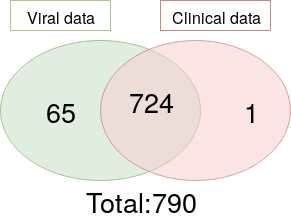

## Merge 

In [44]:
# 1. Load data
with open(PATH_CLINICAL_DATA, 'rb') as file:
    # Keep relevant variables, set index
    df_clinical = pickle.load(file)[VIRAL_CLINICAL_VARIABLES].set_index('gilead_id')
with open(PATH_VIRAL_DATA, 'rb') as file:
    # Set index
    df_viral = pickle.load(file).set_index('id')
# 2. Prepare index structure for merging
df_clinical.columns = pd.MultiIndex.from_product( [ ['clinical'], df_clinical.columns, [''] ] )

In [47]:
# 3. Join the tables on the indexes
df_merge = df_viral.join(other=df_clinical)
df_merge.head(1)

gene                PC                               ...   X                \
pos                  9   28    29    34 41    42 50  ... 127 130    131      
variant              V STOP  W  D  G  T  S  T  A  S  ...   V   K  M   I  V   
id                                                   ...                     
GS-US-174-0149-1884  0    0  1  0  1  0  1  0  0  1  ...   0   1  0   0  1   

gene                       clinical                 
pos                 144          GT   RACE COUNTRY  
variant               A  S                          
id                                                  
GS-US-174-0149-1884   0  1        B  ASIAN     SGP  

[1 rows x 747 columns]

# PCA

In [50]:
pcs, data = viral_seq.pca_impute(df_merge.drop('clinical', axis=1), impute_strategy='mean',
                               n_components=20)

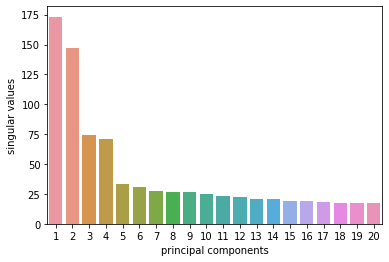

<Figure size 720x216 with 0 Axes>

In [58]:
common.plot_pca(pcs, data, pc_plot_height=None, n_plots=0);

<Figure size 432x288 with 0 Axes>

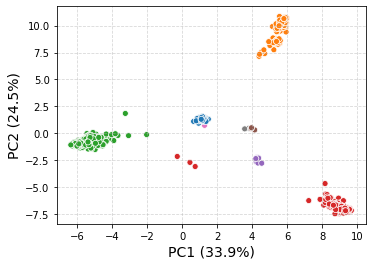

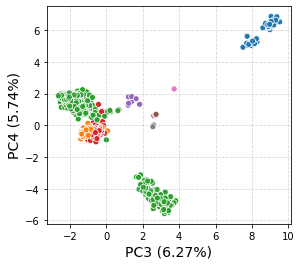

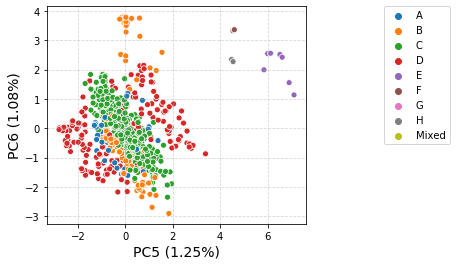

In [78]:
common.plot_pca(pcs, data, pc_plot_height=4, bbox_to_anchor=(1.3,1), singular_values=False,
                n_plots=3, scaled_only=True, hue=df_merge[('clinical','GT','')].values)

<Figure size 432x288 with 0 Axes>

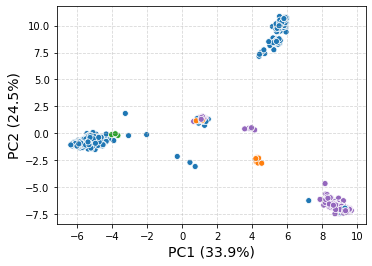

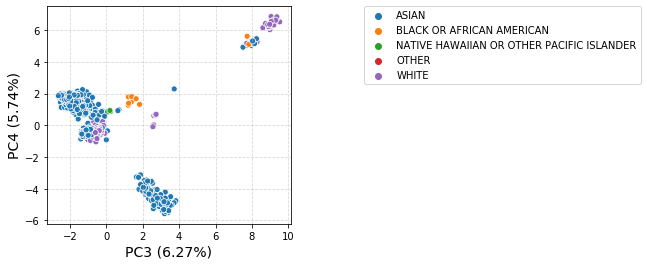

In [77]:
common.plot_pca(pcs, data, pc_plot_height=4, bbox_to_anchor=(1.3,1), singular_values=False,
                n_plots=2, scaled_only=True, hue=df_merge[('clinical','RACE','')].values)

<Figure size 432x288 with 0 Axes>

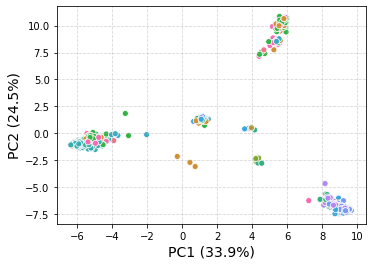

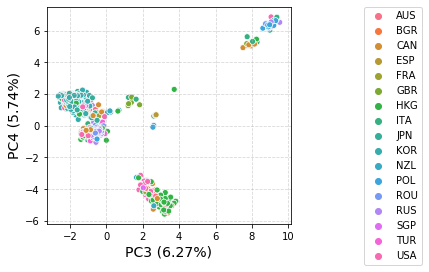

In [79]:
common.plot_pca(pcs, data, pc_plot_height=4, bbox_to_anchor=(1.3,1), singular_values=False,
                n_plots=2, scaled_only=True, hue=df_merge[('clinical','COUNTRY','')].values)